In [1]:
import pandas as pd 
from subs.energy_api import *


df_carbon_forecast_indexed =carbon_api_forecast()


In [2]:
df_carbon_forecast_indexed

,FieldName,Region,Value
EffectiveTime,,,
2024-02-10 17:30:00,CO2_INTENSITY_FORECAST,ALL,265.9484
2024-02-10 18:00:00,CO2_INTENSITY_FORECAST,ALL,262.6884
2024-02-10 18:30:00,CO2_INTENSITY_FORECAST,ALL,249.6902
2024-02-10 19:00:00,CO2_INTENSITY_FORECAST,ALL,242.0181
2024-02-10 19:30:00,CO2_INTENSITY_FORECAST,ALL,240.8457
2024-02-10 20:00:00,CO2_INTENSITY_FORECAST,ALL,239.0218
2024-02-10 20:30:00,CO2_INTENSITY_FORECAST,ALL,231.0885
2024-02-10 21:00:00,CO2_INTENSITY_FORECAST,ALL,230.4130
2024-02-10 21:30:00,CO2_INTENSITY_FORECAST,ALL,223.8624


In [3]:
co2_stats_prior_day, df_carbon_intensity_recent = carbon_api_intensity()

/Users/saeed/Documents/GitHub/telegram-energy-api/subs/energy_api.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_carbon_intensity_recent["Value"] = df_carbon_intensity_recent[


In [4]:
df_carbon_intensity_recent

,FieldName,Region,Value
EffectiveTime,,,
2024-02-09 17:30:00,CO2_INTENSITY,ALL,241.0
2024-02-09 17:45:00,CO2_INTENSITY,ALL,244.0
2024-02-09 18:00:00,CO2_INTENSITY,ALL,243.0
2024-02-09 18:15:00,CO2_INTENSITY,ALL,238.0
2024-02-09 18:30:00,CO2_INTENSITY,ALL,237.0
...,...,...,...
2024-02-10 16:15:00,CO2_INTENSITY,ALL,254.0
2024-02-10 16:30:00,CO2_INTENSITY,ALL,253.0
2024-02-10 16:45:00,CO2_INTENSITY,ALL,250.0


In [5]:
co2_stats_prior_day

{'mean': 237.71875, 'min': 190.0, 'max': 277.0}

In [6]:
df_ = status_classification(df_carbon_forecast_indexed,co2_stats_prior_day)

In [7]:
str(df_.index[0])

'2024-02-10 17:30:00'

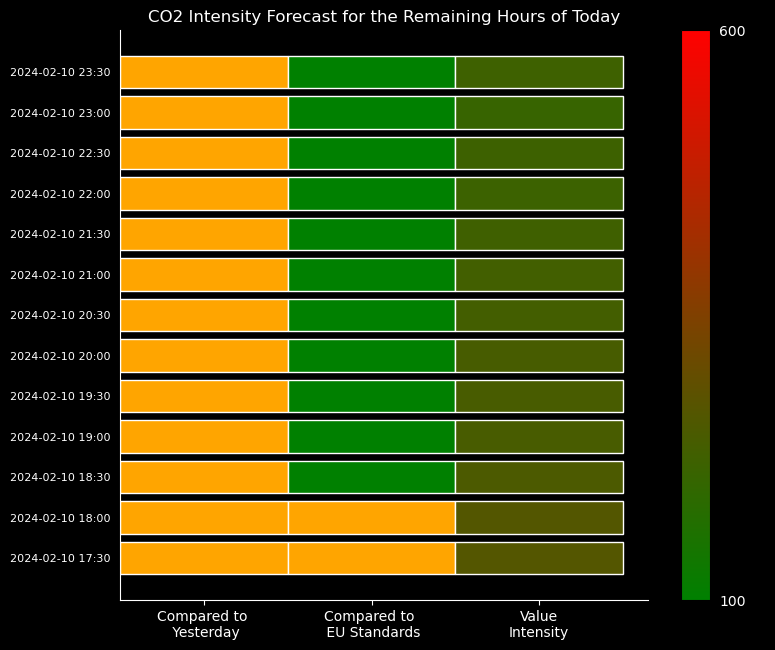

In [8]:
co2_int_plot(df_)

In [22]:
df_.Value.values

array([198.4955, 203.3778, 216.6131, 218.7606, 219.6809, 219.1306])

In [25]:
def create_message(forecast_start_date, co2_values):
    class Message:
        def __init__(self, system, user):
            self.system = system
            self.user = user

    co2_values_str = ', '.join(str(value) for value in co2_values)
    system_template = (
        f"The following data is about the forecasted CO2 emissions starting from {forecast_start_date} "
        f"until the end of today with a step of 30 minutes. Each value represents the CO2 intensity in grams per kWh. "
        f"Your task is to explain this information simply to the user, like a weather commentator. "
        f"\n\nCO2 values are: {co2_values_str}"
    )

    user_template = "When is the best and worst time to use energy today?"

    system = system_template
    user = user_template

    m = Message(system=system, user=user)
    return m

# Example usage
msg = create_message(
    forecast_start_date=str(df_.index[0]), co2_values=[10, 12, 13, 14, 15, 16]
)

m = create_message(
    forecast_start_date="2024-02-08 22:00:00", co2_values=df_.Value.values
)

messages = [
    {"role": "system", "content": msg.system},
    {"role": "user", "content": msg.user},
]


messages = [
    {"role": "system", "content": m.system},
    {"role": "user", "content": m.user},
]

print(messages)


[{'role': 'system', 'content': 'The following data is about the forecasted CO2 emissions starting from 2024-02-08 22:00:00 until the end of today with a step of 30 minutes. Each value represents the CO2 intensity in grams per kWh. Your task is to explain this information simply to the user, like a weather commentator. \n\nCO2 values are: 198.4955, 203.3778, 216.6131, 218.7606, 219.6809, 219.1306'}, {'role': 'user', 'content': 'When is the best and worst time to use energy today?'}]


In [ ]:
# Generating a more descriptive text for CO2 values
co2_values_str = ", ".join(str(value) for value in co2_values)
early_day_advice = "early in the day or in the middle of the day"
late_evening_advice = "the late evening"

system_template = (
    "Based on the forecasted CO2 emissions data, we aim to provide simple and actionable energy usage advice. "
    "The CO2 emissions vary throughout the day, generally lower in the morning and increasing towards the evening. "
    "Given this pattern, when would be the optimal times for energy consumption to minimize environmental impact?"
)


In [25]:
import openai
import os
import datetime
from datetime import timedelta


def create_message(forecast_start_date, co2_values,user_name):
    class Message:
        def __init__(self, system, user):
            self.system = system
            self.user = user

    start_datetime = datetime.datetime.strptime(forecast_start_date, "%Y-%m-%d %H:%M:%S")
    
    # Generate hours list based on the start_datetime and the length of co2_values
    hours = [(start_datetime + timedelta(minutes=30 * i)).strftime('%H:%M') for i in range(len(co2_values))]
    
    time_with_co2 = ", ".join(
        f"{hour} (CO2: {value} g/kWh)" for hour, value in zip(hours, co2_values)
    )

    system_template = (
        f"Forecasted CO2 emissions data from {forecast_start_date}, updating every 30 minutes, is provided below. "
        f"Based on this, you are to give energy usage advice. Identify the most environmentally friendly hours "
        f"for energy consumption to minimize environmental impact. Use the format: Most environmental friendly hours hh:mm, "
        f"medium: hh:mm, and hours to avoid hh:mm. Consider high CO2 > 500, low CO2 < 250, and medium for values in between. "
        f"\n\nCO2 values and corresponding times are: {time_with_co2}"
        f"\n\nProvide advice on the optimal time periods for energy consumption, do not need to give CO2 values to users."
        f"\n\n start with greeting user {user_name}, based on time {forecast_start_date} "
    )

    user_template = "When are the best and worst time periods, on average, to use energy today from the environmental impact perspective in format of hour:minute?"

    system = system_template
    user = user_template

    m = Message(system=system, user=user)
    return m


def opt_gpt_summarise():
    # Ensure your API key is correctly set in your environment variables
    openai.api_key = os.getenv("OPENAI_API_KEY")

    # Construct the messages
    msg = create_message(
        forecast_start_date=str(df_.index[0]), co2_values=df_.Value.values,user_name = 'Saeed'
    )

    messages = [
        {"role": "system", "content": msg.system}
        # {"role": "user", "content": msg.user},
    ]

    try:
        # Making the API call
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",  # or "gpt-3.5-turbo" based on your subscription
            messages=messages,
            max_tokens=600,  # Adjust the number of tokens as needed
            n=1,  # Number of completions to generate
            stop=None,  # Specify any stopping criteria if needed
        )

        # Extracting the response
        # generated_text = response.choices[0].message['content'].strip()
        generated_text = response.choices[0].message.content.strip()

        return generated_text
    except Exception as e:
        return str(e)


In [27]:
opt_gpt_summarise()

'Hello Saeed! Based on the CO2 emissions forecast for today, I can provide you with advice on the optimal time periods for energy consumption.\n\nThe most environmentally friendly hours for energy consumption, with lower CO2 emissions, are as follows: \n- Medium: 17:30, 18:30, 19:30, 20:30, 21:30, 22:00, 23:30\n- Low: 19:00, 20:00, 21:00, 23:00\n \nOn the other hand, the hours to avoid for energy consumption, with higher CO2 emissions, are: \n- High: 18:00, 22:30\n\nIt is recommended to schedule your energy-consuming activities during the medium and low CO2 emission periods to minimize the environmental impact.'

In [21]:
co2_values = [10, 12, 13, 14, 15]
hours = [f"{(22 + i // 2) % 24}:{'00' if i % 2 == 0 else '30'}" for i in range(len(co2_values))]
time_with_co2 = ", ".join(f"{hour} (CO2: {value} g/kWh)" for hour, value in zip(hours, co2_values))

In [23]:
hours

['22:00', '22:30', '23:00', '23:30', '0:00', '0:30']

In [13]:
str(df_.index[0])

'2024-02-10 17:30:00'

In [18]:
import datetime
from datetime import timedelta

start_datetime = datetime.datetime.strptime(str(df_.index[0]), "%Y-%m-%d %H:%M:%S")

# Generate hours list based on the start_datetime and the length of co2_values
hours = [(start_datetime + timedelta(minutes=30 * i)).strftime('%H:%M') for i in range(len(df_.Value.values))]

In [19]:
hours

['17:30',
 '18:00',
 '18:30',
 '19:00',
 '19:30',
 '20:00',
 '20:30',
 '21:00',
 '21:30',
 '22:00',
 '22:30',
 '23:00',
 '23:30']

In [21]:
time_with_co2 = ", ".join(
    f"{hour} (CO2: {value} g/kWh)" for hour, value in zip(hours, df_.Value.values)
)

In [22]:
time_with_co2

'17:30 (CO2: 265.9484 g/kWh), 18:00 (CO2: 262.6884 g/kWh), 18:30 (CO2: 249.6902 g/kWh), 19:00 (CO2: 242.0181 g/kWh), 19:30 (CO2: 240.8457 g/kWh), 20:00 (CO2: 239.0218 g/kWh), 20:30 (CO2: 231.0885 g/kWh), 21:00 (CO2: 230.413 g/kWh), 21:30 (CO2: 223.8624 g/kWh), 22:00 (CO2: 217.5133 g/kWh), 22:30 (CO2: 219.8638 g/kWh), 23:00 (CO2: 207.9371 g/kWh), 23:30 (CO2: 221.5381 g/kWh)'